# Analýza počtu obyvatel podle věkových skupin v NUTS3 oblastech Nizozemska #

Pro správné fungování musíme načíst všechny potřebné balíky.

In [1]:
.libPaths('C:/Users/jkral/Desktop/skola/BI-PRS/libs') # change if needed
library(performance)
library(ggplot2)
library(olsrr)
library(eurostat)
library(moments)
library(cowplot)
library(vtable)
library(corrplot)
library(e1071)  
library(vioplot)
library(see)
library(tidyverse)
library(car)

options(width=160, repr.plot.width=11, repr.plot.height=7)


Attaching package: 'olsrr'


The following object is masked from 'package:datasets':

    rivers


Loading required package: kableExtra

corrplot 0.92 loaded


Attaching package: 'e1071'


The following objects are masked from 'package:moments':

    kurtosis, moment, skewness


Loading required package: sm

Package 'sm', version 2.2-5.7: type help(sm) for summary information

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


-- Attaching core tidyverse packages ---------------------------------------------------------------- tidyverse 2.0.0 --
v dplyr     1.1.0     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v lubridate 1.9.2     v tibble    3.1.8
v purrr     1.0.1     v tidyr     1.3.0
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter()     masks stats::filter()
x dplyr::group_rows() masks 

In [2]:
#install.packages("tidyverse", dependencies=T, lib='C:/Users/jkral/Desktop/skola/BI-PRS/libs')

### Základní analýza dat ###
Nejprve načteme data a zbavíme se řádků, ve kterých některá data chybí.

In [3]:
data <- get_eurostat('demo_r_pjanaggr3')
data <- na.omit(data)
head(data)

unit,sex,age,geo,time,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
NR,F,TOTAL,AT,2022-01-01,4553444
NR,F,TOTAL,AT1,2022-01-01,2000081
NR,F,TOTAL,AT11,2022-01-01,151557
NR,F,TOTAL,AT111,2022-01-01,19074
NR,F,TOTAL,AT112,2022-01-01,83093
NR,F,TOTAL,AT113,2022-01-01,49390


Z dat vyberem pouze ty, která se vztahují k NUTS3 regionům v Nizozemsku. Z nich dále vybereme pouze ta, která jsou z roku 2021 a je známý věk obyvatel. Také můžeme rovnou odstranit sloupce unit a time, jelikož time bude vždy 2021 a unit bude vždy počet lidí.

In [4]:
df <- subset(data, grepl("NL", geo) & nchar(geo) == 5) # vytáhne data, kde je NL a délka geo je 5
df$time <- format(df$time, '%Y')
df <- df[df$sex %in% c('M','F'),]
df$sex <- factor(df$sex)
df <- df[df$time == 2021,]
df <- df[df$age != "UNK",] # removeing unknown age from dataset
age_order <- c("TOTAL", "Y_GE65", "Y15-64", "Y_LT15")
df$age <- factor(df$age, levels=age_order)
df$unit <- NULL
df$time <- NULL
head(df)
tail(df)

sex,age,geo,values
<fct>,<fct>,<chr>,<dbl>
F,TOTAL,NL111,68059
F,TOTAL,NL112,22746
F,TOTAL,NL113,202771
F,TOTAL,NL124,160110
F,TOTAL,NL125,70427
F,TOTAL,NL126,94110


sex,age,geo,values
<fct>,<fct>,<chr>,<dbl>
M,Y_LT15,NL412,37997
M,Y_LT15,NL413,51019
M,Y_LT15,NL414,59740
M,Y_LT15,NL421,20318
M,Y_LT15,NL422,15802
M,Y_LT15,NL423,36724


Nyní se podíváme na souhrnné informace o datech.

In [5]:
summary(df)

 sex         age         geo                values      
 F:160   TOTAL :80   Length:320         Min.   :  3100  
 M:160   Y_GE65:80   Class :character   1st Qu.: 28297  
         Y15-64:80   Mode  :character   Median : 65874  
         Y_LT15:80                      Mean   :109221  
                                        3rd Qu.:126256  
                                        Max.   :741584  

Vidíme, že v datech je 320 záznamů, přičemž unikátních regionů je 40, jelikož jsou dvě pohlaví a jsou 4 věkové kategorie.
Největší kraj má 741 584 obyvatel, zatímco nejmenší má podle dat 3100, což je opravdu velký rozdíl. K tomuto jsme došli po odstranění neznámých hodnot z věku. 
Nyní se podíváme grafy zobrazjící populaci na základě regionu a poté na základě pohlaví a věku.

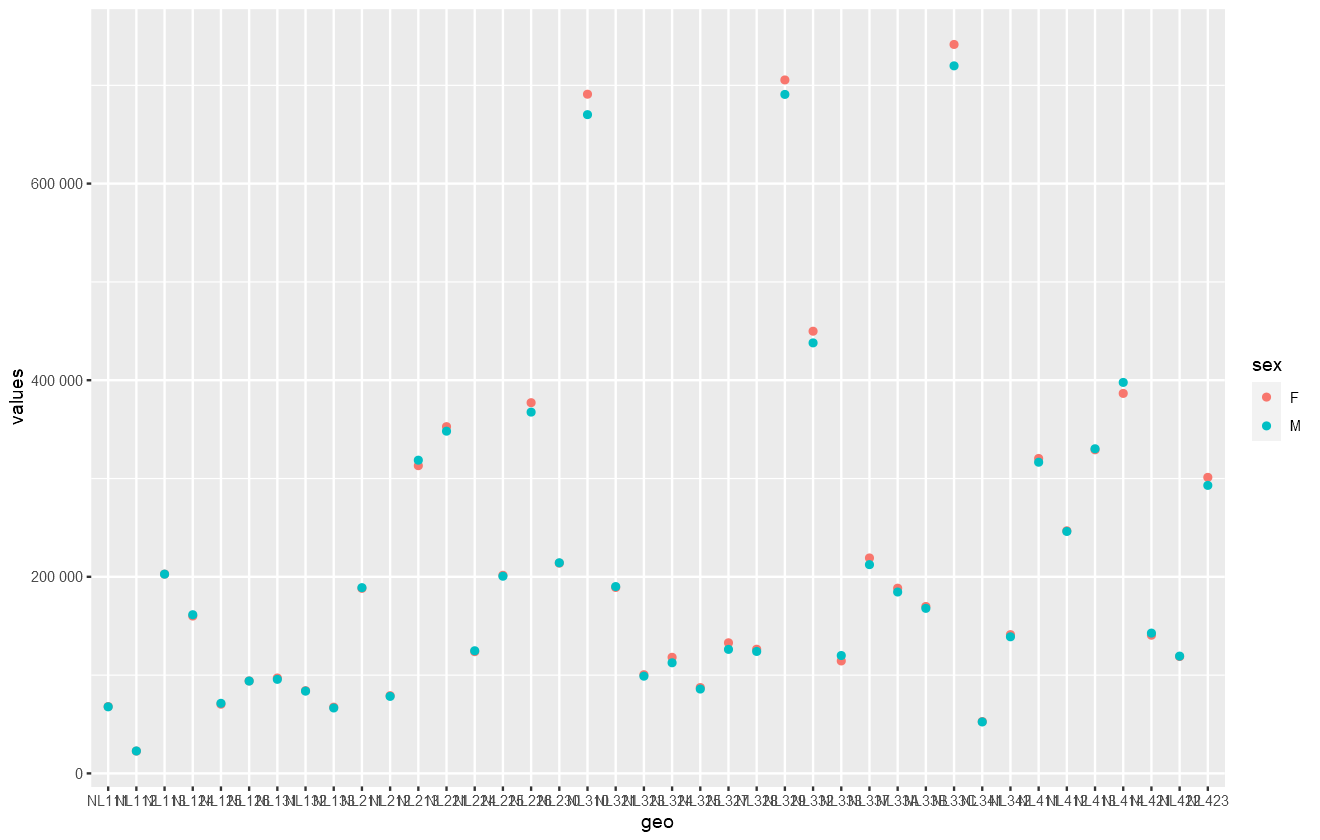

In [6]:
# population based on region
temp <- df[df$age == "TOTAL",]
ggplot(temp, aes(x=geo, y=values, color=sex)) +
    geom_point() +
    scale_y_continuous(labels=scales::label_number(scale = 1))

Z grafu výše vidíme, že ve všech nejlidnatějších krajích je více žen než mužů, zatímco u méně lidnatých krajů jsou tato dvě čísla prakticky shodná. Nyní se podíváme na rozložení počtu obyvatel podle jednotlivých pohlaví.

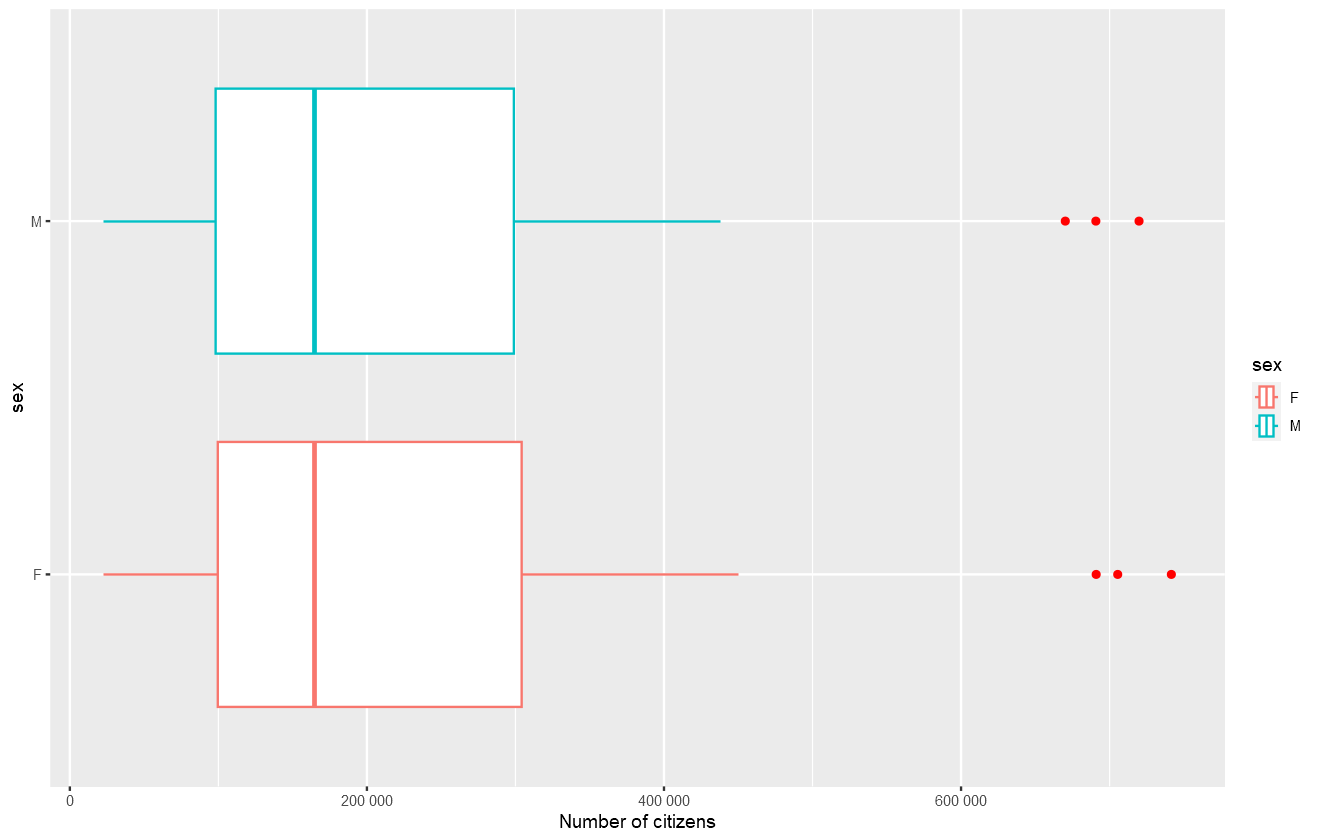

In [7]:
# show boxplot of number of citizens in regions based on sex
temp <- df[df$age == "TOTAL",]
ggplot(temp, aes(x=values, y=sex, color=sex)) +
        geom_boxplot(outlier.color="red", show.legend=T) + 
        scale_x_continuous(labels=scales::label_number(scale = 1)) + 
        labs(x="Number of citizens")

Nyní se podíváme ještě na violin plot toho samého.

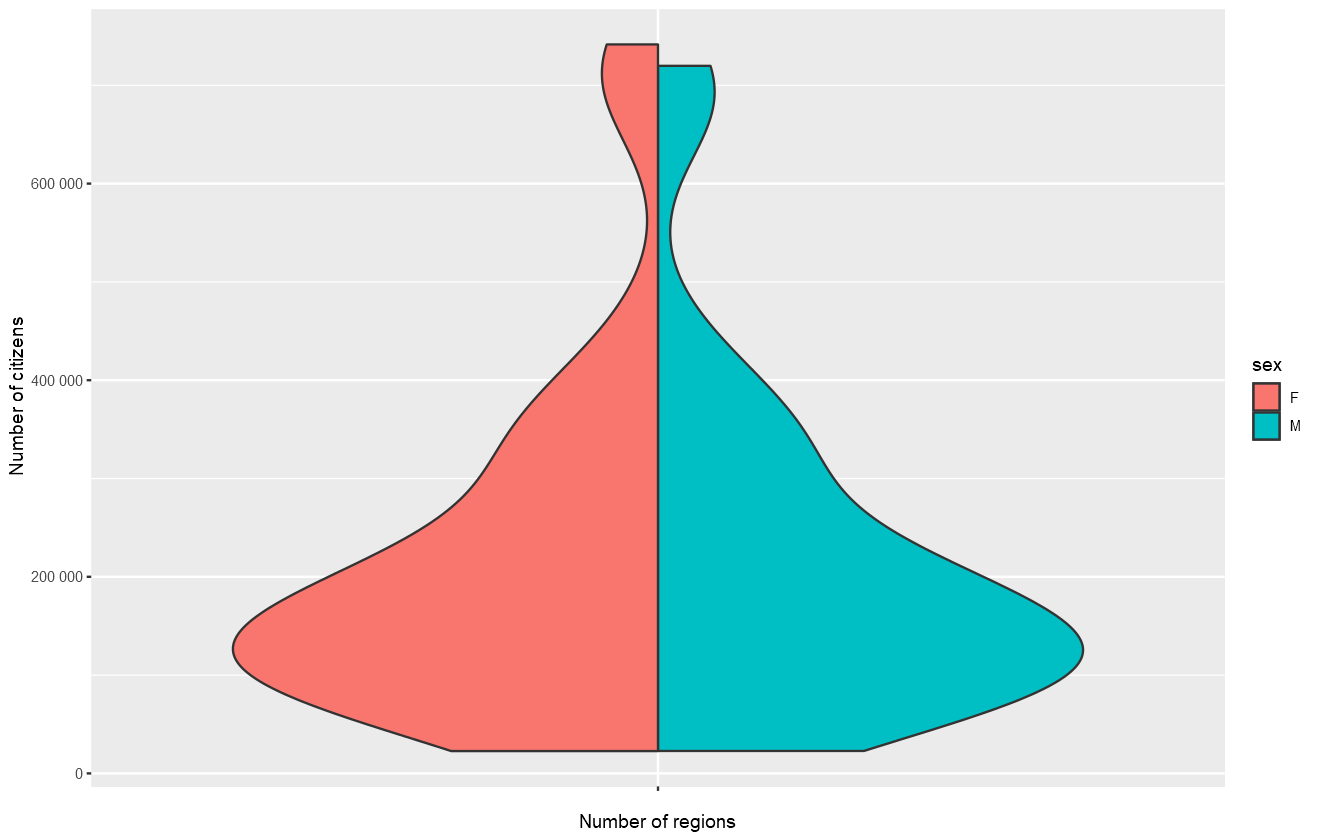

In [8]:
# violin plot of number of citizens based on sex
ggplot(temp, aes(x="", y=values, fill=sex)) +
        geom_violinhalf(data = temp %>% filter(sex=="M")) +
        geom_violinhalf(data = temp %>% filter(sex=="F"), flip=TRUE) + 
        scale_y_continuous(labels=scales::label_number(scale = 1)) + 
        labs(y="Number of citizens", x="Number of regions")

Z grafů výše je vidět, že průměrné počty mužů a žen jsou v krajích prakticky stejné.

Dále zjistíme, jaké je rozložení jednotlivých věkových kategorií.

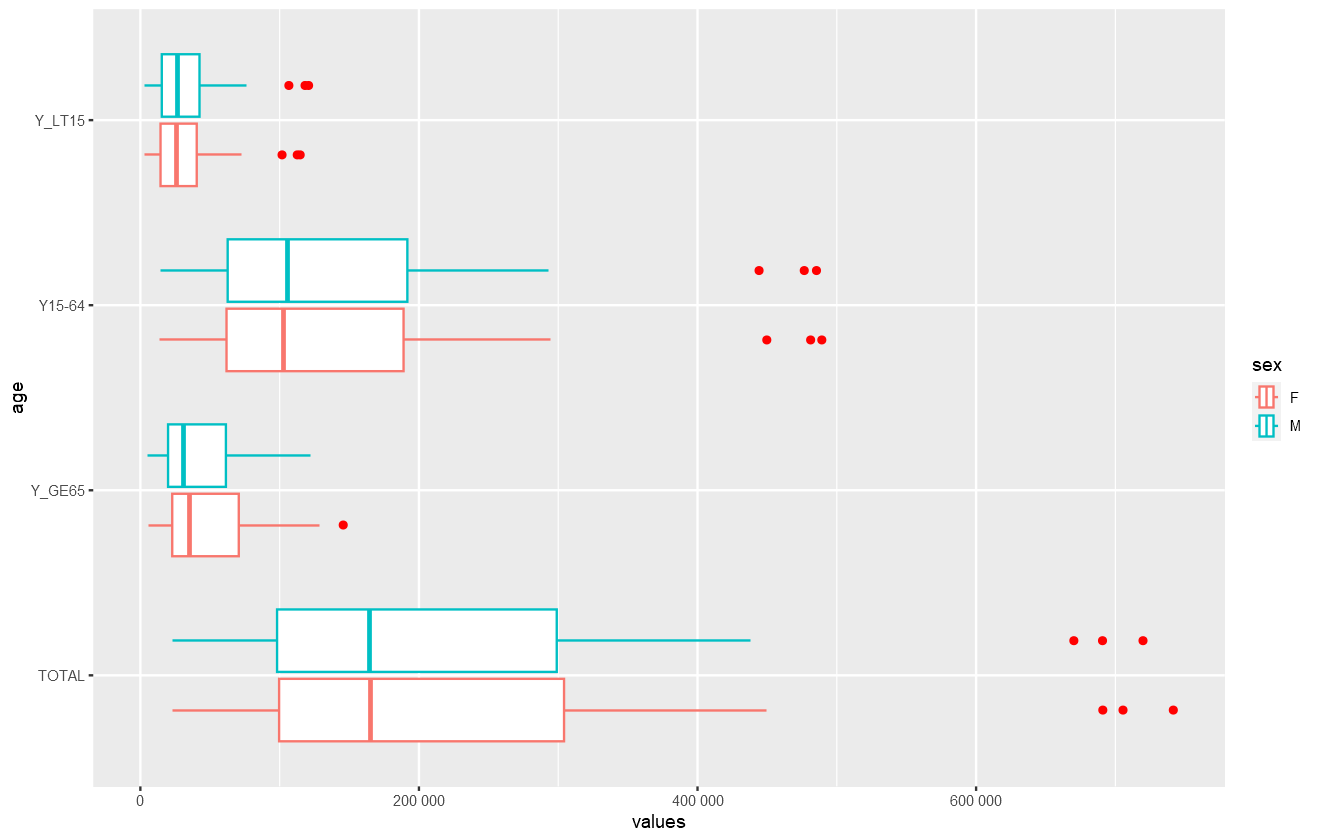

In [9]:
ggplot(df, aes(x=values, y=age, color=sex)) +
        geom_boxplot(outlier.color="red", show.legend=T) + 
        scale_x_continuous(labels=scales::label_number(scale = 1))

Z grafů výše je vidět, že jsou asi tři kraje, ve kterých je mnohem více obyvatel než ve zbylých krajích. Tato statistika neodpovídá pouze u věkové skupiny nad 65 let, což bude způsobeno pravděpodobně větší úmrtností této věkové skupiny.

Nyní provedeme na datech Shapiro-Wilkův test normality, abychom zjistili, zda jsou data normálně rozdělená a které testy na nich přípdaně můžeme později provádět.

In [10]:
shapiro.test(df[df$age == "TOTAL",]$values)


	Shapiro-Wilk normality test

data:  df[df$age == "TOTAL", ]$values
W = 0.80544, p-value = 6.772e-09


Na základě Shapiro-Wilkova testu zamítáme hypotézu, že data jsou z normálního rozdělení, nemůžeme tedy nad daty používat testy, které normalitu rozdělení vyžadují.

### Hypotézy ###

#### Hypotéza 1 ####
Hypotéza: Rozdělení obyvatel v krajích je v Nizozemsku stejné jako u nás.
Alternativa: V Nizozemsku mají jiné rozdělení.
Ke zkoumání použijeme K-S test, jelikož ten zkoumá, zda jsou dva výběry ze stejného rozdělení.

In [11]:
# get data for czech regions
cz <- subset(data, grepl("CZ", geo) & nchar(geo) == 5) # vytáhne data, kde je NL a délka geo je 5
cz$time <- format(cz$time, '%Y')
cz <- cz[cz$sex %in% c('M','F'),]
cz$sex <- factor(cz$sex)
cz <- cz[cz$time == 2021,]
cz <- cz[cz$age != "UNK",]
cz$age <- factor(cz$age)
cz$unit <- NULL
cz$time <- NULL

In [12]:
ks.test(df$values, cz$values, alternative="two.sided")


	Two-sample Kolmogorov-Smirnov test

data:  df$values and cz$values
D = 0.30223, p-value = 5.232e-07
alternative hypothesis: two-sided


Na základě Kolmogorov-Smirnova testu zamítáme hypotézu na úrovni 5 % (zamítli bychom i na nižších úrovních), že kraje v Nizozemsku a kraje v Česku mají stejné počty obyvatel. Z čehož vyplývá, že počty počty obyvatel v krajích jsou výrazně odlišné.

Nyní si vyzualizujeme oba výběry.

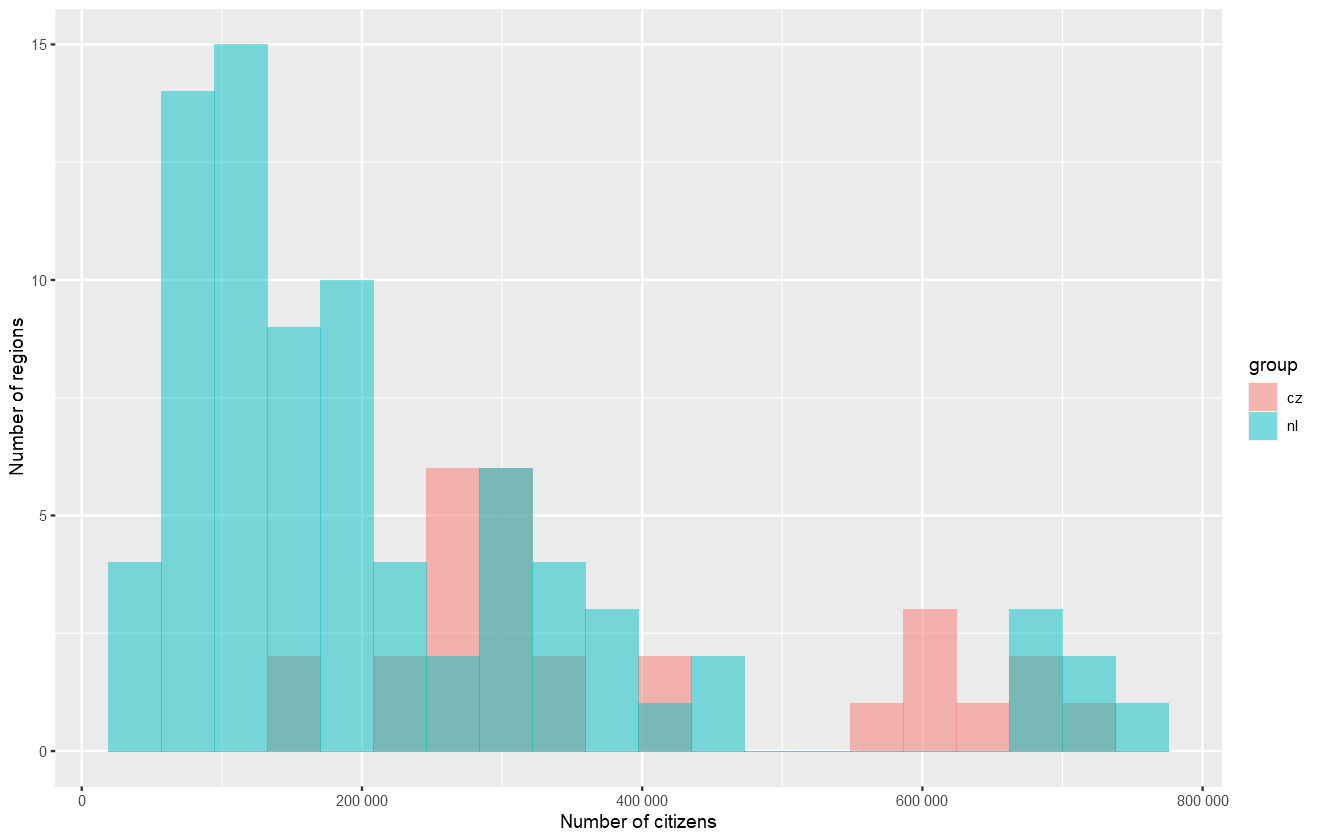

In [13]:
both <- data.frame(values=c(df[df$age=="TOTAL",]$values, cz[cz$age=="TOTAL",]$values),
                  group = rep(c("nl", "cz"), c(length(df[df$age=="TOTAL",]$values), length(cz[cz$age=="TOTAL",]$values))))
ggplot(both, aes(x=values, fill=group)) +
  geom_histogram(alpha=0.5, position="identity", bins=20) +
  labs(x="Number of citizens", y="Number of regions") + 
    scale_x_continuous(labels=scales::label_number(scale = 1))

Graf se shoduje s výsledky testu, v Nizozemsku je očividně více malých krajů.

#### Hypotéza 2 ####
Hypotéza: V Nizozemsku je stejný poměr dětí jako v Srbsku. 
Alternativně je poměr dětí v Srbsku a Nizozemsku rozdílný.

Uděláme dataset pro Srbsko podobně jako pro Nizozemsko výše.

In [14]:
rs <- subset(data, grepl("RS", geo) & nchar(geo) == 5)
rs$time <- format(rs$time, '%Y')
rs <- rs[rs$sex %in% c('M','F'),]
rs$sex <- factor(rs$sex)
rs <- rs[rs$time == 2021,]
rs <- rs[rs$age != "UNK",]
rs$age <- factor(rs$age)
rs$unit <- NULL
rs$time <- NULL

Spočítáme podíl dětí v obyvatelstvu regionů obou zemí.

In [15]:
nether_kids <- df[df$age=="Y_LT15",]$values / df[df$age == "TOTAL",]$values
serbia_kids <- rs[rs$age=="Y_LT15",]$values / rs[rs$age == "TOTAL",]$values

Pomocí Wilcoxonova testu zkusíme zjistit, zda jsou poměry statisticky významně odlišné.

In [16]:
wilcox.test(nether_kids, serbia_kids, "two.sided")


	Wilcoxon rank sum test with continuity correction

data:  nether_kids and serbia_kids
W = 3285, p-value = 7.899e-10
alternative hypothesis: true location shift is not equal to 0


Na základě Wilcoxova testu zamítáme hypotézu, že je v nizozemských krajích stejný poměr dětí jako v srbských krajích na úrovni 5 % ve prospěch alternativy, že podíly dětí jsou různé.

Nyní se podíváme na graf podílů dětí v regionech Srbska a Nizozemska.

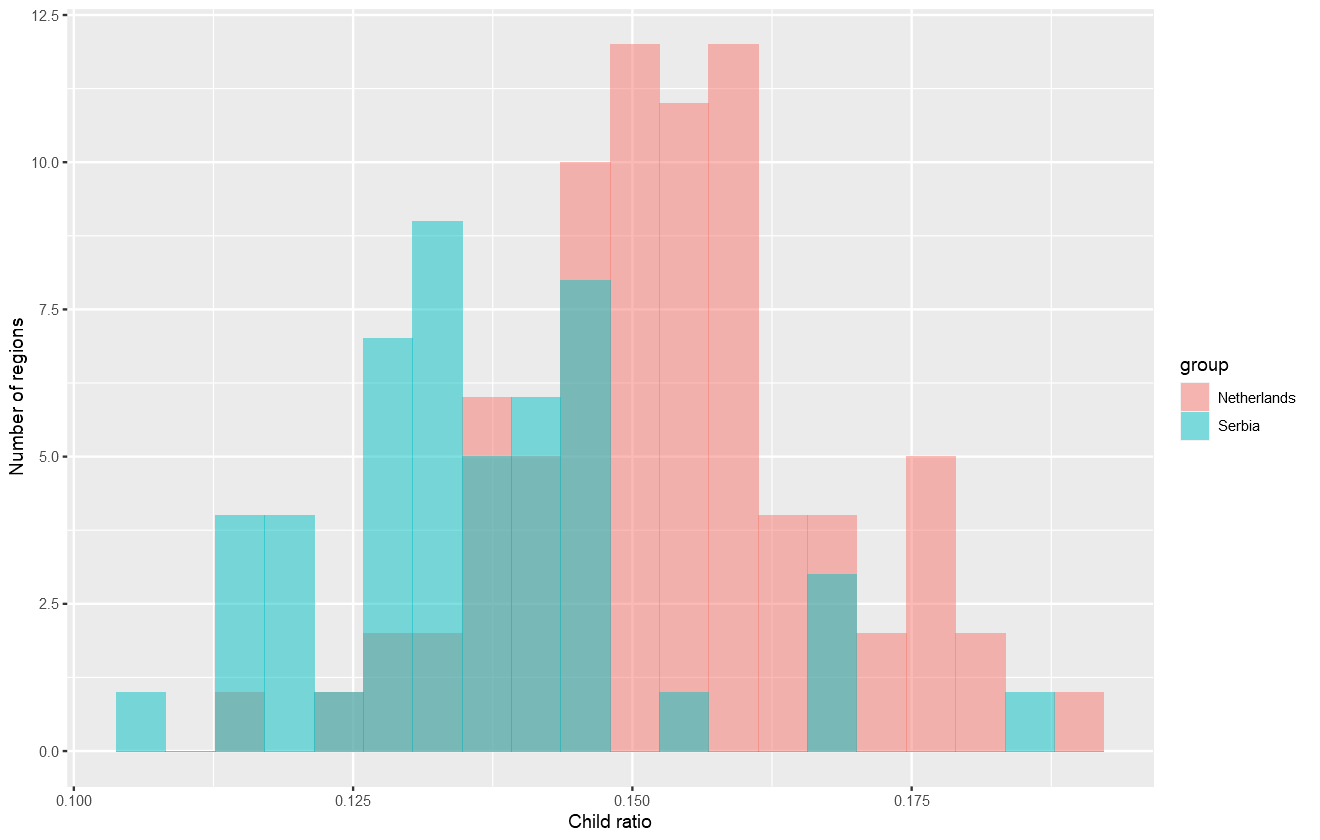

In [17]:
kids <- data.frame(values=c(nether_kids, serbia_kids),
                  group = rep(c("Netherlands", "Serbia"), c(length(nether_kids), length(serbia_kids))))
ggplot(kids, aes(x=values, fill=group)) +
  geom_histogram(alpha=0.5, position="identity", bins=20) +
  labs(x="Child ratio", y="Number of regions") + 
    scale_x_continuous(labels=scales::label_number(scale = 1))

Z grafu je vidět, že v Nizozemsku je viditelně vyšší poměr dětí v obyvatelstvu, což není v rozporu s výše provedeným testem.

#### Hypotéza 3 ####
Chceme otestovat, zda má pohlaví seniorů vliv na jejich počet (dalo by se předpokládat, že žen bude o něco vícě, protože mají obecně vyšší věk dožití) nebo zda jsou tyto počty na pohlaví nezávislé.
Hypotéza: Mezi pohlavím a počtem seniorů není silná korelace. Alternativně je silná korelace mezi pohlavím a počtem seniorů.

In [18]:
seniors = df[df$age == "Y_GE65",]
seniors$sex <- as.numeric(seniors$sex) # males = 2, females = 1
cor.test(seniors$sex, seniors$values)


	Pearson's product-moment correlation

data:  seniors$sex and seniors$values
t = -0.91773, df = 78, p-value = 0.3616
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3158995  0.1190643
sample estimates:
       cor 
-0.1033564 


Na základě výsledku testu nezamítáme nulovou hypotézu na úrovni pěti procent, že počet seniorů nezávisí na pohlaví. Tedy je podobný počet mužů seniorů a žen seniorek. Možná by se dalo mluvit o slabé záporné korelaci (-0,1), což by znamenalo, že je o trochu více žen než mužů starších 64 let, jelikož ženy mají číslo 1 a muži číslo 2 přiřazené funkcí as.numeric().

### Kontingenční tabulka ###
Nyní vytvoříme kontingenční tabulku obsahující počty obyvatel v krajích a jejich pohlaví.

In [19]:
males <- df[df$sex == "M" & df$age == "TOTAL",]$values
females <- df[df$sex == "F" & df$age == "TOTAL",]$values
df_vals <- cbind(males, females)
rownames(df_vals) = unique(df$geo)
df_ct <- as.table(df_vals)
addmargins(df_ct)

,males,females,Sum
NL111,67780,68059,135839
NL112,22841,22746,45587
NL113,202740,202771,405511
NL124,161452,160110,321562
NL125,71350,70427,141777
NL126,93986,94110,188096
NL131,95701,97107,192808
NL132,83734,84205,167939
NL133,66592,67432,134024
NL211,189004,188288,377292


Z tabulky vychází, že v Nizozemsku je o zhruba 100 000 žen více než mužů. V nizozemsku také podle tabulky žije přibližně 17,5 milionů obyvatel, což je na rozlohu Nizozemska úctyhodný počet. Také to vypadá, že ve všech regionech je poměr žen a mužů téměř 1:1.
Hypotéza: počet obyvatel je rozdělen nezávisle na regionu.
Alternativa: počet obyvatel závisí na regionu.
Pomocí Pearsonova Chi-kvadrát testu otestujeme tuto hypotézu.

In [20]:
out <- chisq.test(df_ct)
out


	Pearson's Chi-squared test

data:  df_ct
X-squared = 1577.7, df = 39, p-value < 2.2e-16


Na základě Pearsonova Chi-kvadrát testu nezávislosti zamítáme hypotézu na úrovni 5 % o nezávislosti rozložení počtu obyvatel mezi regiony ve prospěch alternativy. Hypotézu bychom mohli zamítnout i na nižší úrovni, vzhledem k výsledné p-value.

Nyní se podíváme na tabulku očakávaných hodnot.

In [21]:
addmargins(out$expected)

,males,females,Sum
NL111,67521.74,68317.26,135839
NL112,22660.01,22926.99,45587
NL113,201568.08,203942.92,405511
NL124,159839.40,161722.60,321562
NL125,70473.35,71303.65,141777
NL126,93497.22,94598.78,188096
NL131,95839.42,96968.58,192808
NL132,83477.74,84461.26,167939
NL133,66619.55,67404.45,134024
NL211,187541.21,189750.79,377292


Tabulka očekávaných hodnot má ve sloupci sum stejné hodnoty jako původní kontingenční tabulka, což se shoduje s výsledky našeho předchozího testu.